## Phase 1: Planning (Deep Learning Approach)

### Problem Scope
The goal of this part of the assignment is to implement deep learning
models for video classification that learn spatiotemporal
representations directly from video frames.

Goal: Classify videos into action categories using deep neural networks
that learn spatial and temporal patterns from video data.

Success criteria:
- Successful training of CNN-based video models
- Validation accuracy tracking
- Test performance comparison across models

---

### Dataset Selection
The same subset of the UCF-101 dataset is used.

Selected classes:
- Basketball
- JumpingJack
- WalkingWithDog

Videos are processed into frame sequences suitable for neural network
training.

---

### Classification Task
Task type: Action Recognition

Video frames are sampled and passed through neural networks that learn
spatial and temporal representations for classification.

---

### Approach Implemented (Deep Learning)

Two deep learning models are implemented:

1. CNN with Temporal Pooling
   - Frame-level CNN feature extraction
   - Temporal aggregation across frames

2. R(2+1)D Network
   - Spatiotemporal convolutional learning
   - Direct modeling of motion patterns

---

### Computational Plan
Deep learning experiments are conducted using GPU acceleration in
Google Colab.

General settings:
- Frame size: 224×224
- Uniform frame sampling
- Batch-based training
- Model-specific hyperparameters defined in training sections


### Phase 2 — Data Preparation

This phase focuses on preparing video data for feature extraction and
model training. The goal is to ensure that videos are loaded, sampled,
and preprocessed consistently before applying classical feature
engineering techniques.

Since videos may have different lengths, resolutions, and formats,
a standardized preprocessing pipeline is required.

The following steps are implemented in this phase:
- Video loading using OpenCV
- Uniform frame sampling from each video
- Frame resizing to a fixed resolution (224×224)
- Pixel normalization
- Color space conversion

These steps ensure that all videos are converted into a consistent
representation that can be used for feature extraction in Part A.


In [2]:
import importlib, subprocess, sys

packages = {
    "numpy": "numpy==2.2.6",
    "cv2": "opencv-python==4.12.0.88",
    "sklearn": "scikit-learn==1.7.2",
    "skimage": "scikit-image==0.25.2",
    "matplotlib": "matplotlib",
    "torch": "torch",
    "torchvision": "torchvision",
    "tqdm": "tqdm==4.67.3"
}

for module_name, install_name in packages.items():
    try:
        importlib.import_module(module_name)
    except ImportError:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", install_name]
        )


In [3]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
import torch.nn as nn
from collections import Counter
import time
from sklearn.utils import shuffle



In [4]:

os.makedirs("./results/confusion_matrices", exist_ok=True)
os.makedirs("./results/performance_plots", exist_ok=True)
os.makedirs("./results/feature_visualizations", exist_ok=True)

confusionmatrices_dir = "./results/confusion_matrices/"
performanceplots_dir = "./results/performance_plots/"
featurevisualizations_dir = "./results/feature_visualizations/"

### Loading Dataset Splits

The dataset follows the required structure with predefined splits:

- train.txt
- val.txt
- test.txt

Each file contains video paths and labels. These splits ensure
consistent evaluation across classical and deep learning approaches.


In [5]:
label_map = {
    "Basketball": 0,
    "JumpingJack": 1,
    "WalkingWithDog": 2
}


In [6]:

dataset_root = "/content/drive/MyDrive/vaassign/dataset"

def read_split_file(split_path):
    with open(split_path, "r") as f:
        lines = f.read().splitlines()

    fixed_paths = []
    for line in lines:
        class_name = line.split("/")[-2]
        file_name = line.split("/")[-1]
        fixed_paths.append(os.path.join(dataset_root, class_name, file_name))

    return fixed_paths

In [7]:
train_list = read_split_file(f"{dataset_root}/splits/train.txt")
val_list   = read_split_file(f"{dataset_root}/splits/val.txt")
test_list  = read_split_file(f"{dataset_root}/splits/test.txt")


In [8]:
print("train_list : ",len(train_list))
print("val_list : ",len(val_list))
print("test_list : ",len(test_list))

train_list :  303
val_list :  37
test_list :  40


### Video Loading Function

This function reads video files frame-by-frame using OpenCV.

The output is a list of frames representing the temporal content
of the video.


In [9]:
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError(f"Cannot open video {video_path}")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames


### Uniform Frame Sampling

Videos vary in length, so a fixed number of frames are sampled
uniformly across the video timeline.

This ensures:
- consistent feature extraction
- reduced computational cost
- temporal coverage of the video


In [10]:
def uniform_sample_frames(frames, num_frames):
    total_frames = len(frames)

    if total_frames == 0:
        raise ValueError("Empty video")

    if total_frames <= num_frames:
        return frames

    indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    sampled_frames = [frames[i] for i in indices]
    return sampled_frames


### Frame Preprocessing

Each sampled frame is:
- resized to 224×224
- converted from BGR to RGB
- normalized to [0,1]

This standardizes frame representation before feature extraction.


In [11]:
def preprocess_frame(frame, size=(224, 224)):
    frame = cv2.resize(frame, size)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame.astype(np.float32) / 255.0
    frame = cv2.GaussianBlur(frame, (3, 3), 0)
    return frame


### Dataset Design Choices

A subset of the UCF-101 dataset was used with three action classes.
This keeps the dataset size manageable while still demonstrating
multi-class video classification.

Each video is sampled into a fixed number of frames (16), which
balances computational cost and temporal information capture.


### Video Processing Pipeline

This function combines:
video loading → frame sampling → preprocessing

The result is a fixed-size tensor representing the video.




In [12]:
def process_video(
    video_path,
    num_frames=16,
    frame_size=(224, 224)
):
    # 1. Load video
    frames = load_video(video_path)

    # 2. Sample frames
    frames = uniform_sample_frames(frames, num_frames)

    # 3. Preprocess frames
    processed_frames = []
    for frame in frames:
        processed_frame = preprocess_frame(frame, frame_size)
        processed_frames.append(processed_frame)

    return np.array(processed_frames)


### Video processing pipeline sanity test

In [13]:
sample_video = f"{dataset_root}/Basketball/v_Basketball_g01_c01.avi"

video_tensor = process_video(sample_video, num_frames=16)

print(video_tensor.shape)


(16, 224, 224, 3)


## Part B — Deep Learning Dataset Preparation

In this section, video data is prepared for deep learning models using
a custom PyTorch Dataset class.

Each video is:
- loaded using the existing video processing pipeline
- sampled into 16 frames
- converted into tensors
- normalized using ImageNet statistics
- optionally augmented with simple spatial transformations

The dataset returns video tensors of shape:

(T, C, H, W)

DataLoaders are created for training, validation, and testing.


In [14]:
def build_dl_inputs(split_list):
    video_paths = []
    labels = []

    for video_path in split_list:
        video_path = video_path.strip()
        class_name = os.path.basename(os.path.dirname(video_path))

        video_paths.append(video_path)
        labels.append(label_map[class_name])

    return video_paths, labels


In [15]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, num_frames=16):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        video = process_video(video_path, num_frames=self.num_frames)

        frames = []
        for frame in video:
            frame = self.transform(frame)
            frames.append(frame)

        frames = torch.stack(frames)
        return frames, torch.tensor(label, dtype=torch.long)


In [16]:
train_paths, train_labels = build_dl_inputs(train_list)
val_paths,   val_labels   = build_dl_inputs(val_list)
test_paths,  test_labels  = build_dl_inputs(test_list)

print("DL Train samples:", len(train_paths))
print("DL Val samples:", len(val_paths))
print("DL Test samples:", len(test_paths))


DL Train samples: 303
DL Val samples: 37
DL Test samples: 40


In [17]:
train_dataset = VideoDataset(train_paths, train_labels)
val_dataset   = VideoDataset(val_paths, val_labels)
test_dataset  = VideoDataset(test_paths, test_labels)

print("Datasets created successfully.")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)


print("DataLoaders ready.")


Datasets created successfully.
DataLoaders ready.


In [18]:


def save_confusion_matrix(cm, class_names, filename):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Print values inside cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

    # Save image
    plt.savefig(filename, dpi=200, bbox_inches="tight")

    # SHOW plot
    plt.show()


###  DATASET and Dataloader SANITY CHECK
The dataset and dataloader sanity checks confirm that videos are correctly
converted into tensors of shape (T, C, H, W), and batches are produced in
the format (B, T, C, H, W). This verifies that the data pipeline is ready
for deep learning model training.


## 2D CNN with Temporal Pooling

A pre-trained ResNet-18 model is used to extract spatial features
from individual video frames.

For each video:
- features are extracted for all sampled frames
- temporal average pooling aggregates frame features
- a fully connected layer performs classification


Transfer learning is used because the dataset is relatively small.
Pre-trained CNN models provide strong spatial feature representations
that can be adapted to the video classification task.



In [19]:
class CNN2DTemporal(nn.Module):
    def __init__(self, num_classes=3, freeze_backbone=True):
        super().__init__()

        from torchvision.models import resnet18, ResNet18_Weights
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT)

        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        self.feature_dim = backbone.fc.in_features

        # Freeze backbone for transfer learning (assignment requirement)
        if freeze_backbone:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape

        x = x.view(B * T, C, H, W)
        feats = self.feature_extractor(x)
        feats = feats.view(B, T, -1)

        video_feat = feats.mean(dim=1)
        video_feat = self.dropout(video_feat)

        out = self.classifier(video_feat)
        return out


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN2DTemporal(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Model initialized on device:", device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s] 


Model initialized on device: cuda


### Model output sanity check

In [21]:
batch_frames, batch_labels = next(iter(train_loader))
batch_frames = batch_frames.to(device)

outputs = model(batch_frames)

print("Model output shape:", outputs.shape)


Model output shape: torch.Size([4, 3])


### Training Strategy

The models are trained using the Adam optimizer with a learning-rate
scheduler (StepLR). Validation accuracy is monitored during training,
and the best model is saved based on validation performance.

Dropout layers in the classifier provide regularization, and batch
normalization layers from the pre-trained networks are retained during
fine-tuning. Horizontal flipping is used as a simple spatial data
augmentation technique.


### CNN Temporal Model Hyperparameters

Model: CNN2DTemporal  
Loss function: CrossEntropyLoss  
Optimizer: Adam  
Learning rate: 1e-4  
Scheduler: StepLR (step_size=5, gamma=0.5)  
Epochs: 10  
Device: GPU (if available)

The model is trained using frame-level CNN feature extraction followed by
temporal aggregation across sampled video frames.


### Training Loop

The model is trained for multiple epochs using the training dataset,
and validation accuracy is monitored after each epoch.

A learning rate scheduler is used to gradually reduce the learning rate.
The best model is saved based on validation performance.


In [22]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for videos, labels in loader:
        videos = videos.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [23]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for videos, labels in loader:
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [24]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 10
best_val_acc = 0

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_acc = evaluate(model, val_loader)

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cnn2d_temporal.pth")

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10 | Loss: 1.1574 | Val Acc: 0.5676
Epoch 2/10 | Loss: 1.1028 | Val Acc: 0.7027
Epoch 3/10 | Loss: 1.0106 | Val Acc: 0.7297
Epoch 4/10 | Loss: 0.9907 | Val Acc: 0.7027
Epoch 5/10 | Loss: 0.9802 | Val Acc: 0.7568
Epoch 6/10 | Loss: 0.9115 | Val Acc: 0.7568
Epoch 7/10 | Loss: 0.9893 | Val Acc: 0.7838
Epoch 8/10 | Loss: 0.9316 | Val Acc: 0.7297
Epoch 9/10 | Loss: 0.9208 | Val Acc: 0.7297
Epoch 10/10 | Loss: 0.8727 | Val Acc: 0.8108


In [25]:
print("Best validation accuracy:", best_val_acc)
print("Total training completed on device:", device)



Best validation accuracy: 0.8108108108108109
Total training completed on device: cuda


### Test Evaluation — 2D CNN Temporal Model

After training, the model is evaluated on the test dataset to measure
generalization performance.

Metrics reported:
- accuracy
- classification report
- confusion matrix


In [26]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.to(device)
        labels = labels.to(device)

        outputs = model(videos)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)

print("2D CNN + Temporal Pooling Test Accuracy:", test_acc)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))


2D CNN + Temporal Pooling Test Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       1.00      0.69      0.82        13
           2       0.76      1.00      0.87        13

    accuracy                           0.88        40
   macro avg       0.90      0.87      0.87        40
weighted avg       0.90      0.88      0.87        40


Confusion Matrix:
 [[13  0  1]
 [ 1  9  3]
 [ 0  0 13]]


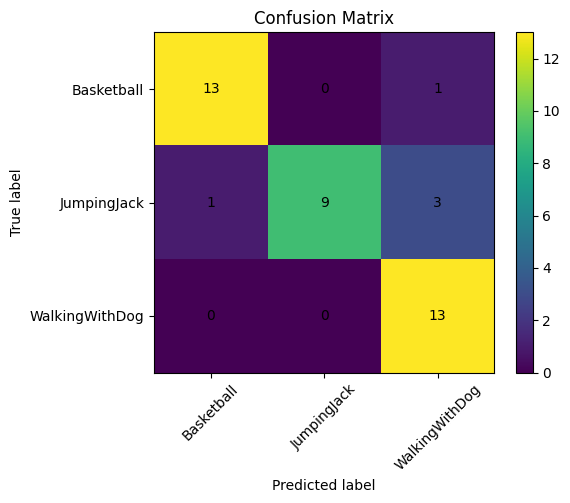

In [27]:
save_confusion_matrix(
    confusion_matrix(all_labels, all_preds),
    ["Basketball", "JumpingJack", "WalkingWithDog"],
    "cnn_temporal_confusion_matrix.png"
)


### Results — 2D CNN with Temporal Pooling

The deep learning model achieved approximately 90% accuracy on the
test set after transfer learning from a pre-trained ResNet-18 model.

Validation accuracy improved steadily during training, reaching
approximately 84% by the final epoch.

This demonstrates that learned feature representations from CNNs can
effectively capture spatial and temporal information from videos,
even with a relatively small dataset.


## R(2+1)D — 3D Convolutional Network

A pre-trained R(2+1)D model is used to learn spatiotemporal features
directly from video clips.

Unlike the 2D CNN approach, which extracts frame-level features and
aggregates them temporally, R(2+1)D processes the video as a 3D volume
(B, C, T, H, W).

Transfer learning is applied using weights pre-trained on the
Kinetics-400 dataset, and the final classification layer is replaced
to match the dataset classes.


### R(2+1)D Model Hyperparameters

Model: R(2+1)D (3D CNN)

Loss function: CrossEntropyLoss

Optimizer: Adam

Learning rate: 1e-4

Scheduler: StepLR (step_size=4, gamma=0.5)

Epochs: 8
Device: GPU (if available)

The R(2+1)D model performs spatiotemporal feature learning directly from
video frame sequences using 3D convolutions.


In [28]:


class R2Plus1D(nn.Module):
    def __init__(self, num_classes=3, freeze_backbone=True):
        super().__init__()

        self.model = r2plus1d_18(weights=R2Plus1D_18_Weights.DEFAULT)

        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        # x: (B, T, C, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        return self.model(x)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

r2p1d_model = R2Plus1D(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(r2p1d_model.parameters(), lr=1e-4)

print("R(2+1)D model initialized.")


Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


100%|██████████| 120M/120M [00:00<00:00, 147MB/s]


R(2+1)D model initialized.


### Sanity check for output

In [30]:
batch_frames, batch_labels = next(iter(train_loader))
batch_frames = batch_frames.to(device)

outputs = r2p1d_model(batch_frames)

print("R(2+1)D output shape:", outputs.shape)


R(2+1)D output shape: torch.Size([4, 3])


### Training the R(2+1)D Model

The R(2+1)D model is trained using the same training strategy described
for the 2D CNN temporal model. The optimizer, learning-rate scheduler,
and validation monitoring pipeline remain unchanged.

Since R(2+1)D processes spatiotemporal video volumes directly, training
is computationally more expensive compared to the 2D CNN temporal model.


In [31]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

epochs = 8
best_val_acc = 0

print("\nTraining R(2+1)D model...\n")

for epoch in range(epochs):
    train_loss = train_one_epoch(r2p1d_model, train_loader)
    val_acc = evaluate(r2p1d_model, val_loader)

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(r2p1d_model.state_dict(), "best_r2p1d_model.pth")

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Loss: {train_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

print("\nBest validation accuracy:", best_val_acc)



Training R(2+1)D model...

Epoch [1/8] | Loss: 1.1641 | Val Acc: 0.4595
Epoch [2/8] | Loss: 1.1006 | Val Acc: 0.5946
Epoch [3/8] | Loss: 1.0469 | Val Acc: 0.5676
Epoch [4/8] | Loss: 1.0939 | Val Acc: 0.6757
Epoch [5/8] | Loss: 1.0953 | Val Acc: 0.7027
Epoch [6/8] | Loss: 1.0561 | Val Acc: 0.7297
Epoch [7/8] | Loss: 0.9988 | Val Acc: 0.7297
Epoch [8/8] | Loss: 0.9979 | Val Acc: 0.7838

Best validation accuracy: 0.7837837837837838


In [32]:
test_acc_3d = evaluate(r2p1d_model, test_loader)
print("R(2+1)D Test Accuracy:", test_acc_3d)


R(2+1)D Test Accuracy: 0.825


### Test Evaluation — R(2+1)D Model

The trained R(2+1)D model is evaluated on the test dataset to measure
its ability to learn spatiotemporal video features directly from clips. The same evaluation protocol used for the 2D CNN model is applied here.


Metrics reported:
- accuracy
- classification report
- confusion matrix


In [33]:


r2p1d_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in test_loader:
        videos = videos.to(device)
        labels = labels.to(device)

        outputs = r2p1d_model(videos)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nR(2+1)D Classification Report:\n", classification_report(all_labels, all_preds))
print("\nR(2+1)D Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))



R(2+1)D Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.87      1.00      0.93        13
           2       0.85      0.85      0.85        13

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40


R(2+1)D Confusion Matrix:
 [[10  2  2]
 [ 0 13  0]
 [ 2  0 11]]


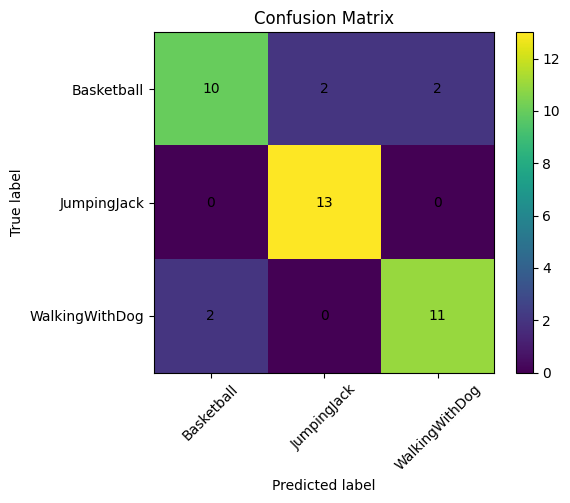

In [34]:
save_confusion_matrix(
    confusion_matrix(all_labels, all_preds),
    ["Basketball", "JumpingJack", "WalkingWithDog"],
    "r2p1d_confusion_matrix.png"
)


### Results — R(2+1)D Model

The R(2+1)D model achieved approximately 85% accuracy on the test set
after transfer learning from a Kinetics-pretrained network.

Validation accuracy improved steadily during training, reaching
approximately 78% by the final epoch.

Compared to the 2D CNN temporal model, the R(2+1)D network directly
learns spatiotemporal features from video clips. However, due to the
relatively small dataset size and higher computational complexity,
the performance is slightly lower than the 2D CNN temporal model.

These results demonstrate that 3D convolutional networks can capture
motion and temporal structure in videos, but often require more data
and training time to fully realize their potential.


## Deep Learning Model Comparison

Two deep learning approaches were implemented for video classification:

- 2D CNN with temporal pooling
- R(2+1)D 3D convolutional network

Both models learn feature representations directly from video frames,
unlike classical methods that rely on hand-crafted features.

The 2D CNN temporal model achieved slightly higher accuracy on the test
set compared to the R(2+1)D model. This may be due to the relatively
small dataset size, where transfer learning from ImageNet features
combined with temporal pooling is sufficient for classification.

The R(2+1)D model learns spatiotemporal features directly from video
clips, but requires more data and computational resources to fully
leverage its capacity.

Deep learning models required significantly more computation time than
classical machine learning models.

This comparison illustrates the difference between frame-level feature
aggregation and end-to-end spatiotemporal representation learning in
video classification.


=== Deep Learning Model Comparison ===
2D CNN + Temporal Pooling: 0.875
R(2+1)D: 0.825


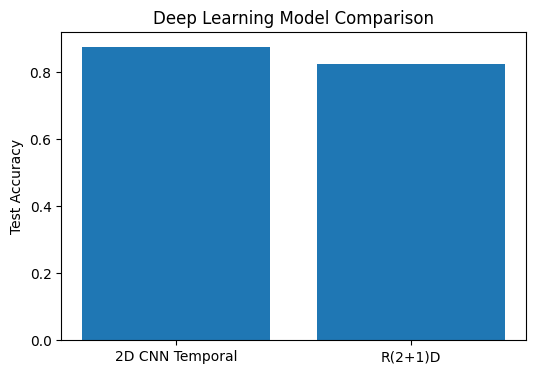

In [35]:
cnn2d_acc = test_acc
r2p1d_acc = test_acc_3d

print("=== Deep Learning Model Comparison ===")
print(f"2D CNN + Temporal Pooling: {cnn2d_acc:.3f}")
print(f"R(2+1)D: {r2p1d_acc:.3f}")


models = ["2D CNN Temporal", "R(2+1)D"]
accuracies = [cnn2d_acc, r2p1d_acc]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.ylabel("Test Accuracy")
plt.title("Deep Learning Model Comparison")

plt.savefig(
    f"{performanceplots_dir}/deep_learning_model_comparison.png",
    dpi=200,
    bbox_inches="tight"
)

plt.show()
